Discretized Data

In [1]:
import numpy as np

l = 4
m = 100
a = np.linspace(-2 * np.pi, 2 * np.pi, m)
b = np.sin(a)


Gaussian Sum Model

In [2]:
def phi(x, t, l=4):
    result = 0
    for i in range(l):
        alpha = x[3*i]
        mu = x[3*i + 1]
        sigma = x[3*i + 2]
        result += alpha * np.exp(-((t - mu)**2) / (2 * sigma**2))
    return result


Objective

In [3]:
def objective(x, a, b):
    return 0.5 * np.sum((np.array([phi(x, aj) for aj in a]) - b)**2)

def residuals(x, a, b):
    return np.array([phi(x, aj) - bj for aj, bj in zip(a, b)])


Line Search (Backtracking)

In [4]:
def backtracking(f, grad, x, p, alpha=1.0, rho=0.5, c=1e-4):
    fx = f(x)
    grad_fx = grad(x)
    while f(x + alpha * p) > fx + c * alpha * np.dot(grad_fx, p):
        alpha *= rho
    return alpha


Gradient (via finite differences or autodiff)

In [5]:
from scipy.optimize import approx_fprime

def gradient(f, x):
    epsilon = np.sqrt(np.finfo(float).eps)
    return approx_fprime(x, f, epsilon)


Quasi-Newton Methods

BFGS

In [6]:
def bfgs(f, x0, a, b, tol=1e-6, max_iter=100):
    x = x0.copy()
    H = np.eye(len(x))
    history = [x0.copy()]

    f_wrapped = lambda x_: f(x_, a, b)
    grad_wrapped = lambda x_: gradient(f_wrapped, x_)

    for i in range(max_iter):
        grad = grad_wrapped(x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad
        alpha = backtracking(f_wrapped, grad_wrapped, x, p)
        s = alpha * p
        x_new = x + s
        y = grad_wrapped(x_new) - grad
        rho = 1.0 / (y @ s)
        H = (np.eye(len(x)) - rho * np.outer(s, y)) @ H @ (np.eye(len(x)) - rho * np.outer(y, s)) + rho * np.outer(s, s)
        x = x_new
        history.append(x.copy())
    return x, history

DFP

In [7]:
def dfp(f, grad_f, x0, a, b, tol=1e-6, max_iter=100):
    x = x0.copy()
    n = len(x)
    H = np.eye(n)
    history = [x0.copy()]
    for _ in range(max_iter):
        grad = grad_f(lambda x_: objective(x_, a, b), x)
        if np.linalg.norm(grad) < tol:
            break
        p = -H @ grad
        f_wrapped = lambda x_: objective(x_, a, b)
        grad_wrapped = lambda x_: grad_f(f_wrapped, x_)
        alpha = backtracking(f_wrapped, grad_wrapped, x, p)
        s = alpha * p
        x_new = x + s
        y = grad_f(lambda x_: objective(x_, a, b), x_new) - grad
        
        ys = y @ s
        if abs(ys) < 1e-12:
            print("Warning: Division by near-zero detected in rho computation (y @ s ≈ 0). Skipping update.")
            # Optionally break or continue here if you want to stop or skip update
            break
        
        rho = 1.0 / ys
        Hy = H @ y
        
        # Instead of checking Hy == 0 (vector), check its norm to avoid division by zero
        Hy_norm = np.linalg.norm(Hy)
        if Hy_norm < 1e-12:
            print("Warning: Hy vector norm is near zero, skipping Hessian update to avoid division by zero.")
            history.append(x_new.copy())
            x = x_new
            continue
        
        denom = y @ Hy
        if abs(denom) < 1e-12:
            print("Warning: Division by near-zero detected in Hessian update denominator (y @ Hy ≈ 0). Skipping update.")
            history.append(x_new.copy())
            x = x_new
            continue
        
        H = H + np.outer(s, s) / ys - np.outer(Hy, Hy) / denom
        x = x_new
        history.append(x.copy())
    return x, history


SR1 (Trust Region Framework)

In [8]:
def sr1_trust_region(f, grad_f, x0, a, b, delta=1.0, tol=1e-6, max_iter=100):
    x = x0.copy()
    n = len(x)
    B = np.eye(n)
    history = [x0.copy()]
    for _ in range(max_iter):
        g = grad_f(lambda x_: objective(x_, a, b), x)
        if np.linalg.norm(g) < tol:
            break
        # Trust-region step (Cauchy point or truncated CG)
        p = -np.linalg.solve(B + 1e-6*np.eye(n), g)
        if np.linalg.norm(p) > delta:
            p = p * delta / np.linalg.norm(p)
        s = p
        x_new = x + s
        y = grad_f(lambda x_: objective(x_, a, b), x_new) - g
        Bs = B @ s
        diff = y - Bs
        denom = diff @ s
        if abs(denom) > 1e-8:
            B += np.outer(diff, diff) / denom
        x = x_new
        history.append(x.copy())
    return x, history


Identify x*

In [9]:
import matplotlib.pyplot as plt

np.random.seed(42)

x0 = np.random.rand(12)
x_opt, _ = bfgs(objective, x0, a, b)
x_star = x_opt


Plot ϕ(x*, t) vs sin(t)

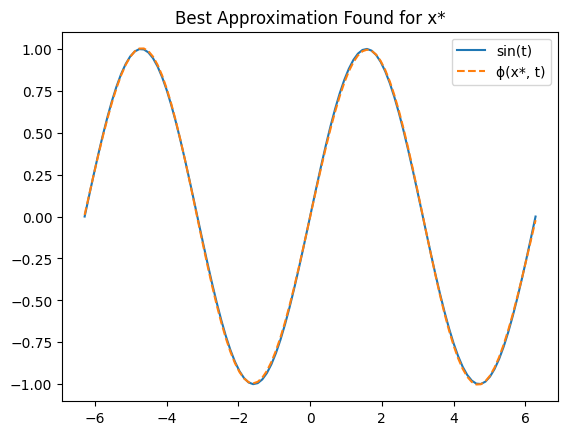

In [10]:
plt.plot(a, b, label="sin(t)")
plt.plot(a, [phi(x_star, aj) for aj in a],'--', label="ϕ(x*, t)")
plt.legend()
plt.title("Best Approximation Found for x*")
plt.show()


evaulate_runs from Diego

In [11]:
import time

np.random.seed(42)

def evaluate_runs(objective, x_star, method, method_name, num_runs=5, scales=[0.5, 0.75, 1.0, 1.5, 2.0]):
    for i, scale in enumerate(scales[:num_runs]):
        print(f"\n--- Run {i + 1} (scale = {scale}) ---")
        x0 = np.random.randn(3 * l) * scale
        start_time = time.time()
        x_final, history = method(x0)
        end_time = time.time()
        runtime = end_time - start_time

        distance = np.linalg.norm(x_final - x_star)
        k = len(history) - 2
        if k < 0:
            print("Insufficient iterations for convergence analysis.")
            continue

        xk = history[k]
        xk1 = history[k + 1]
        lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
        qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)

        print(f"Stopping criterion: ||g|| < 1e-6 or max_iter = 100")
        print(f"Final iterate x̄:\n{x_final}")
        print(f"Distance to x*: {distance:.6f}")
        print(f"ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = {lk:.6f}")
        print(f"qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = {qk:.6f}")
        print(f"Runtime: {runtime:.4f} seconds")

        # Plotting result
        plt.figure()
        plt.plot(a, b, label="sin(t)")
        plt.plot(a, phi(x_final, a), '--', label="phi(x̄; t)")
        plt.title(f"Run {i + 1}: phi(x̄; t) vs sin(t) ({method_name})")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.show()


BFGS

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.08087692 -2.43884726 -0.90580568 -6.61896721  4.54789333  2.35306505
  5.70135931  4.02269275  4.6624169  -3.32644361 -0.74400247 -1.46631788]
Distance to x*: 13.175773
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.008635
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.077213
Runtime: 3.1976 seconds


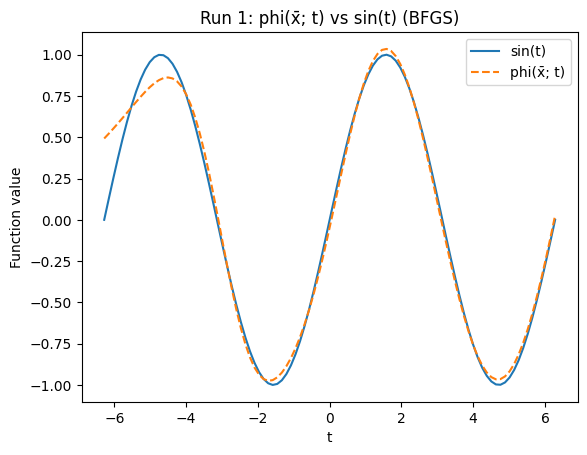


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.94108205 -1.25549646 -0.64931478  0.94108215  1.25549663  0.64931486
 -0.52611864 -2.25261086  0.40855513  0.52611841  2.25261097 -0.40855506]
Distance to x*: 5.205394
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.192108
Runtime: 1.9630 seconds


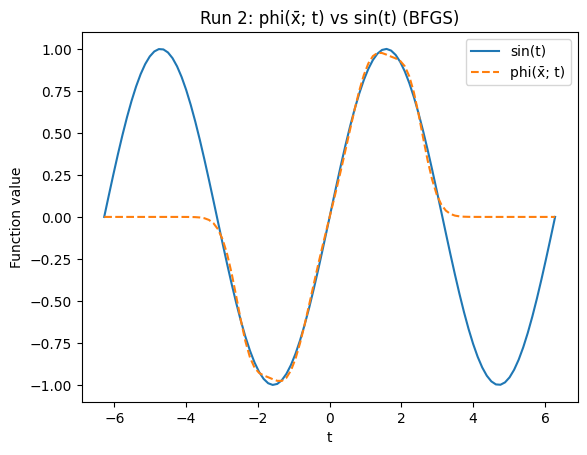


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-15.31700109  -3.19956228   1.60943067 -16.39984055  -1.15207041
   1.59631911  -5.12070117 -19.859996    13.19058289  27.20524084
  -2.24998905   2.24166708]
Distance to x*: 43.367214
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.998854
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.023006
Runtime: 3.1246 seconds


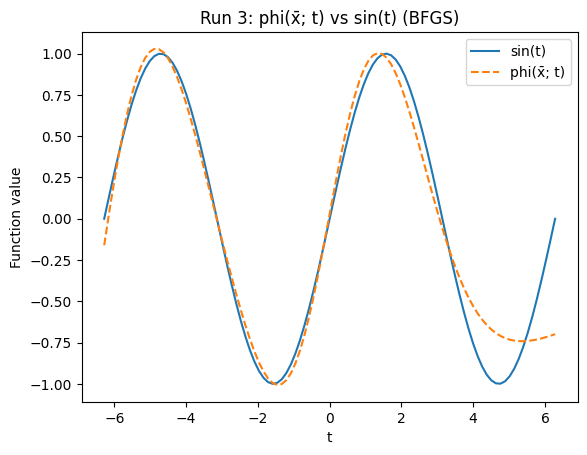


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.89017328 -5.01289713 -0.64993703  8.7286056   1.49971979  1.72310819
 -7.66697905  1.473488   -2.12260517  0.73681289 -3.7933164   0.69346254]
Distance to x*: 13.790752
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.008206
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.073707
Runtime: 3.1565 seconds


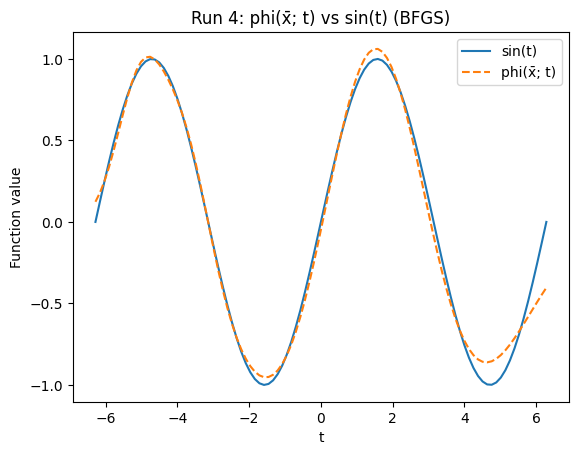


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[  9.12942179  -4.53362214   2.29275993 -10.5100487   -2.62512923
   4.27976928  10.79368139   2.53465785  -3.47808585  -7.56989804
   4.32956708   2.08093957]
Distance to x*: 21.915950
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.011843
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.046716
Runtime: 3.1414 seconds


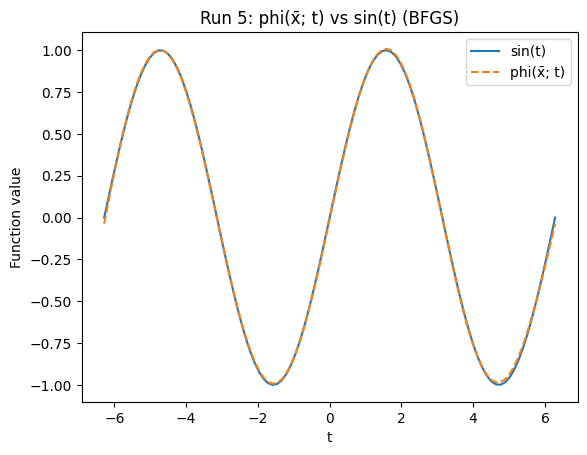

In [12]:
print("BFGS")
bfgs_method = lambda x0: bfgs(objective, x0, a, b)
evaluate_runs(objective, x0, bfgs_method, "BFGS")

DFP

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.07807187e+00 -1.52527702e+00  7.56714122e-01  5.47571892e-01
  2.24661194e+00  4.11244923e-01  1.44941156e+00  6.95135820e-01
  8.87896610e-04  9.40959937e-01  1.24399449e+00 -6.37039850e-01]
Distance to x*: 4.374717
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.228586
Runtime: 2.0494 seconds


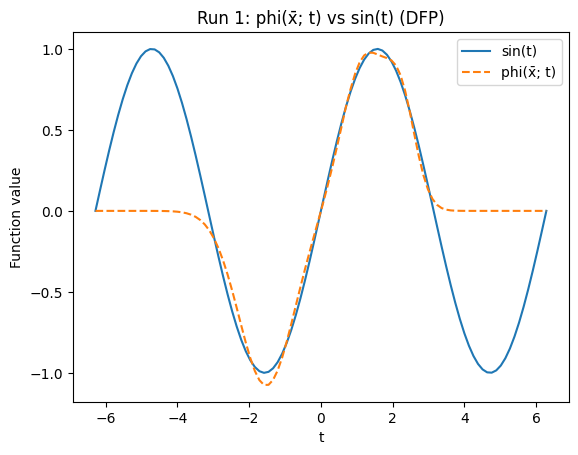


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.16066599  4.70246541 -0.81910248 -1.60381293  3.01961579  0.93232383
 -1.09007298 -1.46229447  0.79846582  1.99863098  2.51554154 -1.25232151]
Distance to x*: 7.218019
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000643
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.138720
Runtime: 3.1295 seconds


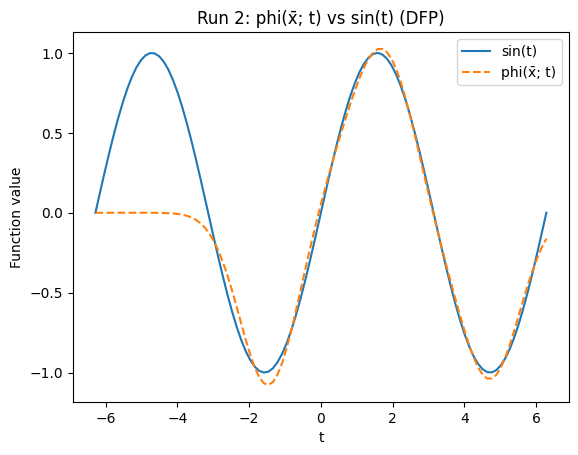


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-1.02554504 -1.62967917  0.70170692 -0.06417027 -0.1665051   0.44777504
  1.08075901  1.48499818 -0.79288011 -0.13558777 -0.64138481 -0.75894074]
Distance to x*: 4.093776
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.996106
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.242375
Runtime: 0.5146 seconds


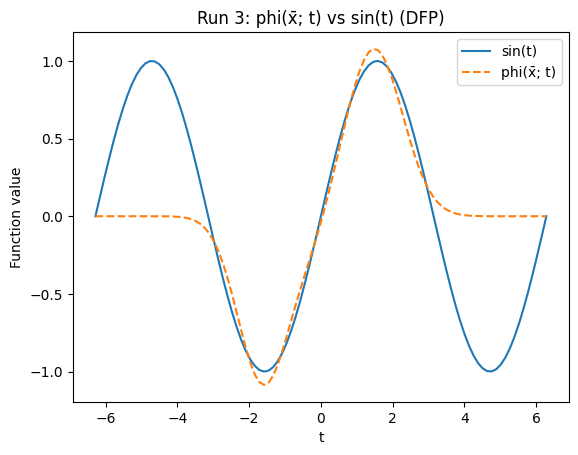


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 4.44180416e-01  3.91596447e-01  7.63341407e-03 -1.04361861e+01
 -3.19642862e-01  2.40981820e+00  8.20421694e+00  7.79565291e-01
 -1.91222459e+00  4.40014722e+00 -2.48507821e+00  2.42648994e+00]
Distance to x*: 14.920831
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.006463
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.067890
Runtime: 3.2146 seconds


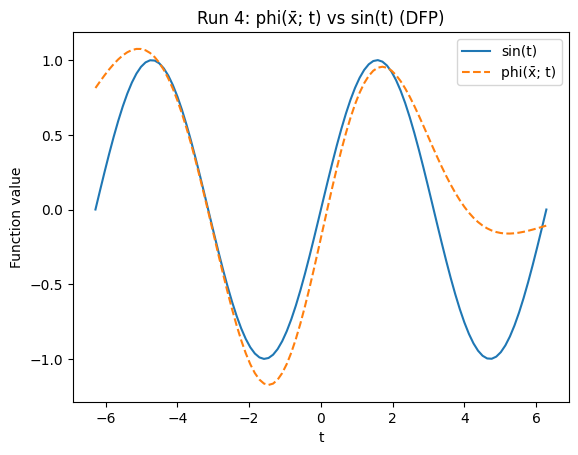


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-6.98063882  1.66077212 -2.5250378   0.22638083  3.80561669 -1.12330503
  1.00602392  4.76908146 30.09971921  6.99639756  1.59805275 -1.70324503]
Distance to x*: 31.871335
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.003897
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.031621
Runtime: 3.1376 seconds


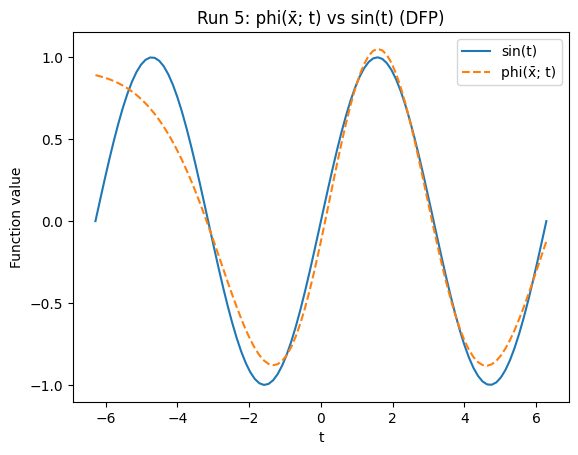

In [13]:
print("DFP")
dfp_method = lambda x0: dfp(objective, gradient, x0, a, b)
evaluate_runs(objective, x0, dfp_method, "DFP")

SR1

--- Run 1 (scale = 0.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 1.09181006  1.55677171  0.71568529 -1.0686773  -1.68068123  0.67490484
 -0.36799629 -0.61544192 -0.21970167 -0.00350084 -2.38434107  0.65643225]
Distance to x*: 4.091887
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.002692
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.245704
Runtime: 1.9913 seconds


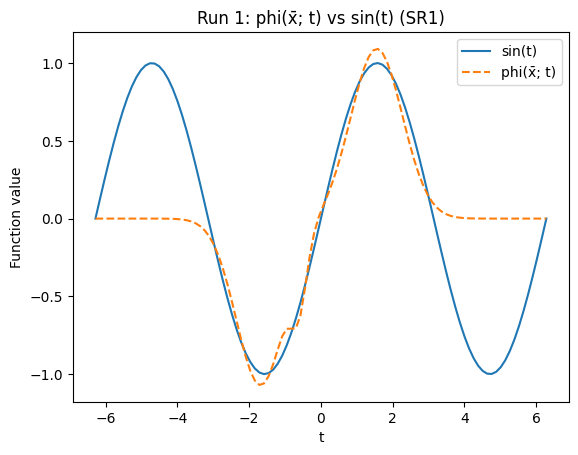


--- Run 2 (scale = 0.75) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-0.78112433 -0.975422   -0.66882367  0.94019842  1.79554052  0.62039742
  0.45405098  0.67318307 -0.68213173 -0.71571619 -2.05413406 -0.5080623 ]
Distance to x*: 4.514975
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.026155
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.233223
Runtime: 1.9907 seconds


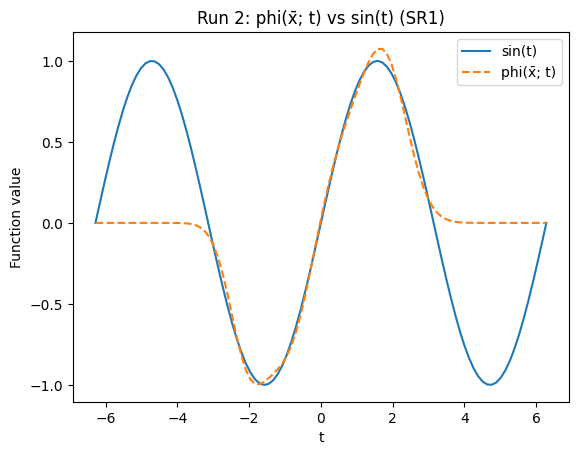


--- Run 3 (scale = 1.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.52610377  2.25260918 -0.40855136 -0.5261127  -2.25261866 -0.4085499
  0.94108271  1.25550337 -0.64932356 -0.94108376 -1.25549981 -0.64932105]
Distance to x*: 4.457463
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.000000
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.224343
Runtime: 1.9787 seconds


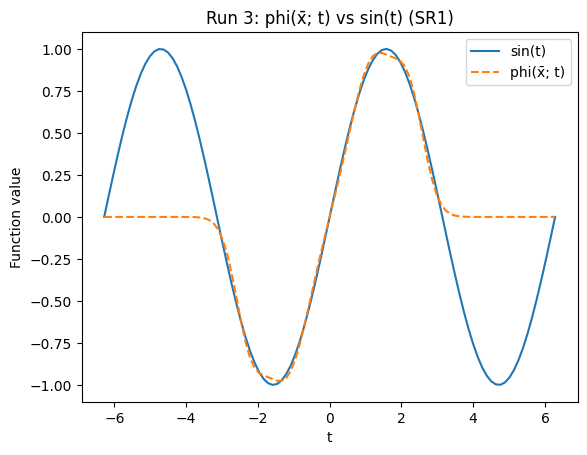


--- Run 4 (scale = 1.5) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.72470733  0.98618424  0.02002942 -0.47290401 -6.77560621  0.52351621
 -3.65302    -1.77861737  1.30657417  2.43086134 -1.96717231  2.28173859]
Distance to x*: 8.936805
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.942776
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.099457
Runtime: 2.0331 seconds


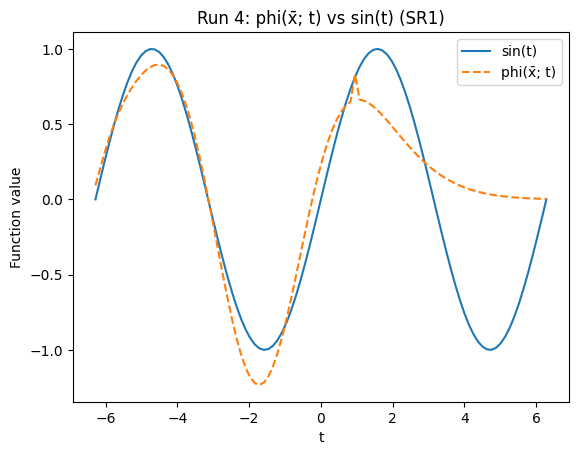


--- Run 5 (scale = 2.0) ---
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 7.86570781e-01 -7.55141772e-01 -1.73442299e-02 -1.44012994e+00
 -1.59095559e+00  8.46312170e-01  3.06247970e-02 -2.66724770e+00
  8.60177624e+00  5.69509326e-01 -2.22814644e+01  1.84643603e+01]
Distance to x*: 29.854298
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.034099
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.035819
Runtime: 2.0077 seconds


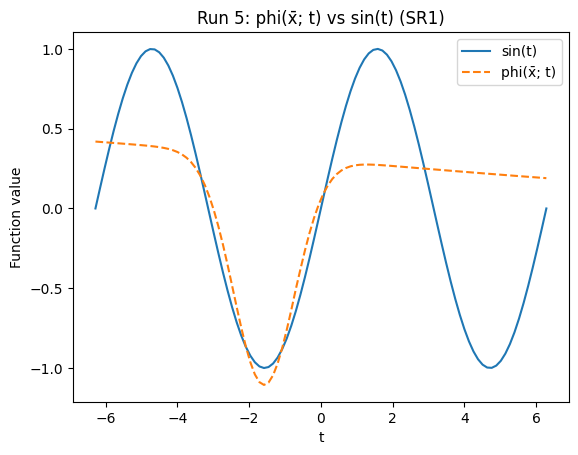

In [14]:
print("SR1")
sr1_method = lambda x0: sr1_trust_region(objective, gradient, x0, a, b)
evaluate_runs(objective, x0, sr1_method, "SR1")

Newton method

In [15]:
from scipy.optimize import approx_fprime
import numpy as np
import time

def jacobian(x, a, epsilon=1e-6):
    n = len(x)
    m = len(a)
    J = np.zeros((m, n))
    for i in range(n):
        x1 = x.copy()
        x1[i] += epsilon
        x2 = x.copy()
        x2[i] -= epsilon
        f1 = np.array([phi(x1, t) for t in a])
        f2 = np.array([phi(x2, t) for t in a])
        J[:, i] = (f1 - f2) / (2 * epsilon)
    return J

def backtracking(f, grad, x, p, alpha=1.0, rho=0.5, c=1e-4):
    fx = f(x)
    grad_fx = grad(x)
    while f(x + alpha * p) > fx + c * alpha * np.dot(grad_fx, p):
        alpha *= rho
    return alpha

def newton(objective, x0, a, b, max_iter=100, tol=1e-6, verbose=False):
    x = x0.copy()
    history = [x.copy()]

    for k in range(max_iter):
        # Compute residual and Jacobian
        r = residuals(x, a, b)
        J = jacobian(x, a)

        # Gradient and Gauss-Newton Hessian
        g = J.T @ r
        H = J.T @ J  # Gauss-Newton approximation

        grad_norm = np.linalg.norm(g)
        if verbose:
            print(f"Iter {k}: ||grad|| = {grad_norm:.2e}")

        # Stopping criterion
        if grad_norm < tol:
            if verbose:
                print(f"Converged at iteration {k}")
            break

        # Check conditioning
        cond = np.linalg.cond(H)
        if cond > 1e12:
            print(f"Hessian ill-conditioned at iteration {k} (cond = {cond:.2e}).")
            break

        try:
            # Check positive definiteness
            np.linalg.cholesky(H)
        except np.linalg.LinAlgError:
            print(f"Hessian not positive definite at iteration {k}.")
            break

        try:
            p = -np.linalg.solve(H, g)
        except np.linalg.LinAlgError:
            print(f"Hessian not invertible at iteration {k}.")
            break

        # Define objective and grad for backtracking
        def obj(x_):
            return objective(x_, a, b)

        def grad_f(x_):
            r_ = residuals(x_, a, b)
            J_ = jacobian(x_, a)
            return J_.T @ r_

        # Line search (optional in Newton, but keeps step safe)
        alpha = backtracking(obj, grad_f, x, p)

        x += alpha * p
        history.append(x.copy())

    return x, history


Newton

--- Run 1 (scale = 0.5) ---
Hessian ill-conditioned at iteration 1 (cond = 3.24e+19).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.11259053 -0.50677444  0.06923007  0.06209091 -0.35194219  0.01913526
  0.18036513 -0.51550643 -0.01588758  0.28039956  0.54332164  0.53097597]
Distance to x*: 2.479984
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 0.981110
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.388138
Runtime: 0.0777 seconds


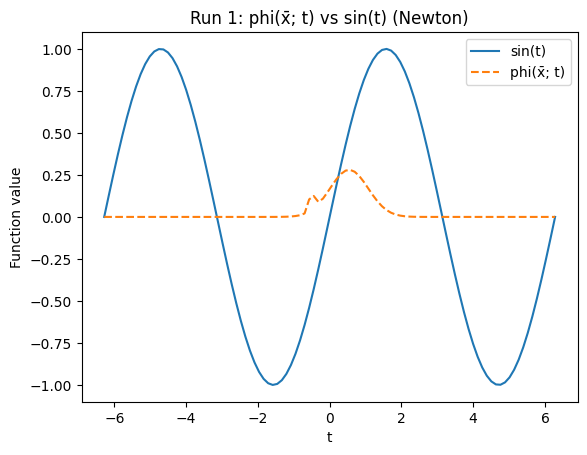


--- Run 2 (scale = 0.75) ---
Hessian ill-conditioned at iteration 18 (cond = 2.08e+18).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 1.44938965e-01  1.62778314e-01  7.74756840e-01 -5.13700848e+02
  2.55739098e+04 -3.75384687e+03  1.07564876e-01  3.45444728e+00
  6.31081418e-01  7.22770831e-01  1.66317733e+00  7.11579668e-01]
Distance to x*: 25852.928910
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1672.579985
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 108.209163
Runtime: 0.8331 seconds


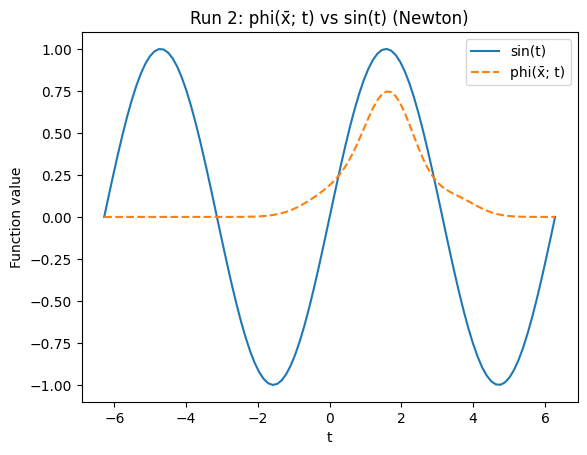


--- Run 3 (scale = 1.0) ---
Hessian ill-conditioned at iteration 4 (cond = 9.20e+18).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[-3.84262615e-01 -1.16700885e+00 -3.01917996e-01 -7.11981812e-01
  3.31850446e+01  1.48633973e+01 -1.07270101e+00 -2.21191455e+00
 -1.77006886e-02 -2.83709150e-01 -3.21134403e+00 -3.90108476e+00]
Distance to x*: 36.896658
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 2.975327
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.239929
Runtime: 0.1920 seconds


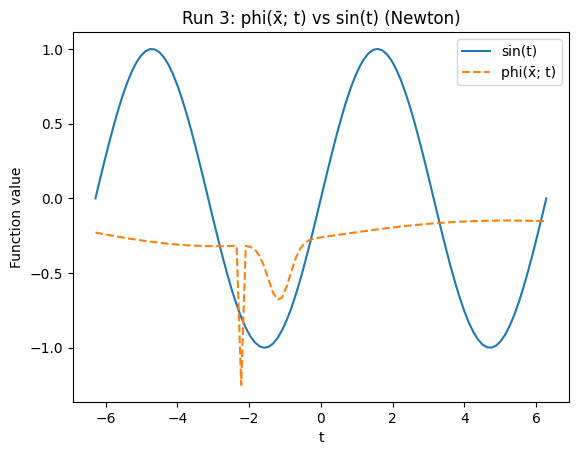


--- Run 4 (scale = 1.5) ---
Hessian ill-conditioned at iteration 3 (cond = 4.42e+14).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ 0.86013322  6.31529641  2.51984955 -9.50534402  6.30427729 -3.18500245
  0.22764609 -1.06321748 -3.6679102   4.95564891  7.95583922 -7.03938527]
Distance to x*: 18.718976
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 3.367921
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.605957
Runtime: 0.1465 seconds


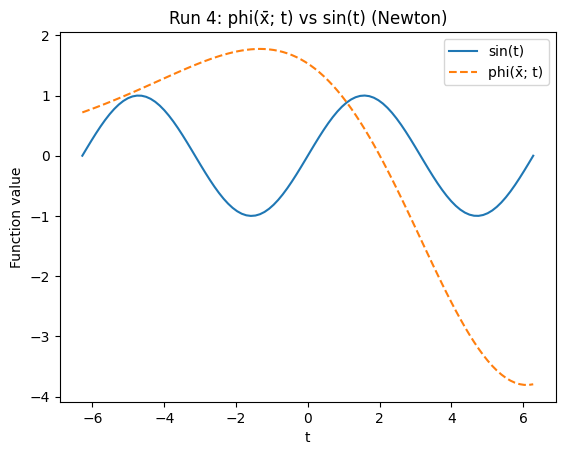


--- Run 5 (scale = 2.0) ---
Hessian ill-conditioned at iteration 38 (cond = 1.24e+12).
Stopping criterion: ||g|| < 1e-6 or max_iter = 100
Final iterate x̄:
[ -2.93334086  -0.45583319   1.24636897   1.21784234  -2.41844177
  -0.63591834  -0.01256466 -10.21703155  10.65202818   0.68269469
   0.03655602   3.13727458]
Distance to x*: 15.791932
ℓₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*|| = 1.327798
qₖ = ||xₖ₊₁ - x*|| / ||xₖ - x*||² = 0.111642
Runtime: 1.9237 seconds


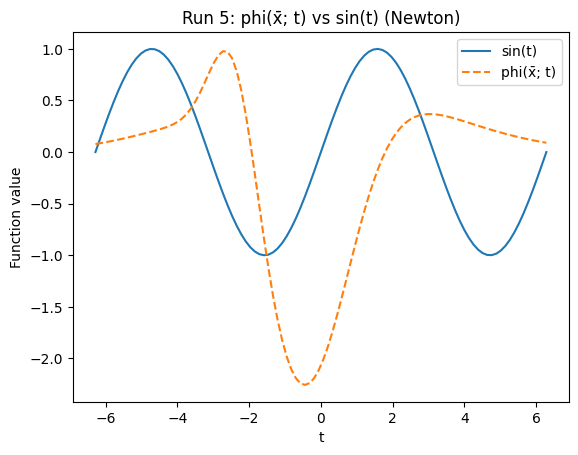

In [17]:
print("Newton")
newton_method = lambda x0: newton(objective, x0, a, b)
evaluate_runs(objective, x0, newton_method, "Newton")

In [18]:
def classify_convergence(lk, qk, tol=1e-2):
    if qk < tol:
        return "Quadratic"
    elif lk < 1 and qk >= tol:
        return "Superlinear"
    elif lk < 1:
        return "Linear"
    else:
        return "Diverging or very slow"

def evaluate_all_runs(objective, phi, x_star, methods, method_names, a, b, num_runs=5, scales=[0.5, 0.75, 1.0, 1.5, 2.0]):
    assert len(methods) == len(method_names), "Each method must have a corresponding name."
    
    convergence_summary = {name: {"Quadratic": 0, "Superlinear": 0, "Linear": 0, "Diverging or very slow": 0,
                                  "Total time": 0.0, "Success count": 0} for name in method_names}
    
    for run_idx, scale in enumerate(scales[:num_runs]):
        print(f"\n=== Run {run_idx + 1} (scale = {scale}) ===")
        x0 = np.random.randn(12) * scale

        plt.figure(figsize=(10, 6))
        plt.plot(a, b, label="sin(t)", linewidth=2)

        for method, name in zip(methods, method_names):
            start_time = time.time()
            x_final, history = method(x0)
            runtime = time.time() - start_time

            distance = np.linalg.norm(x_final - x_star)
            k = len(history) - 2
            if k < 0:
                print(f"{name}: Insufficient iterations.")
                continue

            xk = history[k]
            xk1 = history[k + 1]
            lk = np.linalg.norm(xk1 - x_star) / np.linalg.norm(xk - x_star)
            qk = np.linalg.norm(xk1 - x_star) / (np.linalg.norm(xk - x_star) ** 2)
            category = classify_convergence(lk, qk)

            convergence_summary[name][category] += 1
            convergence_summary[name]["Total time"] += runtime
            if distance < 1e-4:
                convergence_summary[name]["Success count"] += 1

            print(f"\n{name}")
            print(f"Final ||x̄ - x*||: {distance:.6f}")
            print(f"ℓₖ = {lk:.6f}, qₖ = {qk:.6f} → {category}")
            print(f"Runtime: {runtime:.4f}s")

            # Plot model prediction
            plt.plot(a, phi(x_final, a), '--', label=f"{name}", linewidth=1.5)

        plt.title(f"Run {run_idx + 1}: Model vs sin(t)")
        plt.xlabel("t")
        plt.ylabel("Function value")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Final summary
    print("\n=== Method Summary ===")
    for name in method_names:
        total = sum(convergence_summary[name][key] for key in ["Quadratic", "Superlinear", "Linear", "Diverging or very slow"])
        print(f"\nMethod: {name}")
        print(f"Successful convergence to x*: {convergence_summary[name]['Success count']}/{num_runs}")
        print("Rates of convergence distribution:")
        for rate in ["Quadratic", "Superlinear", "Linear", "Diverging or very slow"]:
            count = convergence_summary[name][rate]
            print(f"  {rate}: {count}")
        avg_time = convergence_summary[name]["Total time"] / num_runs
        print(f"Average runtime: {avg_time:.4f} seconds")


=== Run 1 (scale = 0.2) ===

BFGS
Final ||x̄ - x*||: 18.843507
ℓₖ = 1.036919, qₖ = 0.057059 → Diverging or very slow
Runtime: 3.2109s

DFP
Final ||x̄ - x*||: 3.914661
ℓₖ = 0.999583, qₖ = 0.255237 → Superlinear
Runtime: 3.1268s

SR1
Final ||x̄ - x*||: 4.634552
ℓₖ = 1.008309, qₖ = 0.219371 → Diverging or very slow
Runtime: 2.0147s

Newton
Final ||x̄ - x*||: 14.004954
ℓₖ = 1.005750, qₖ = 0.072227 → Diverging or very slow
Runtime: 4.4601s


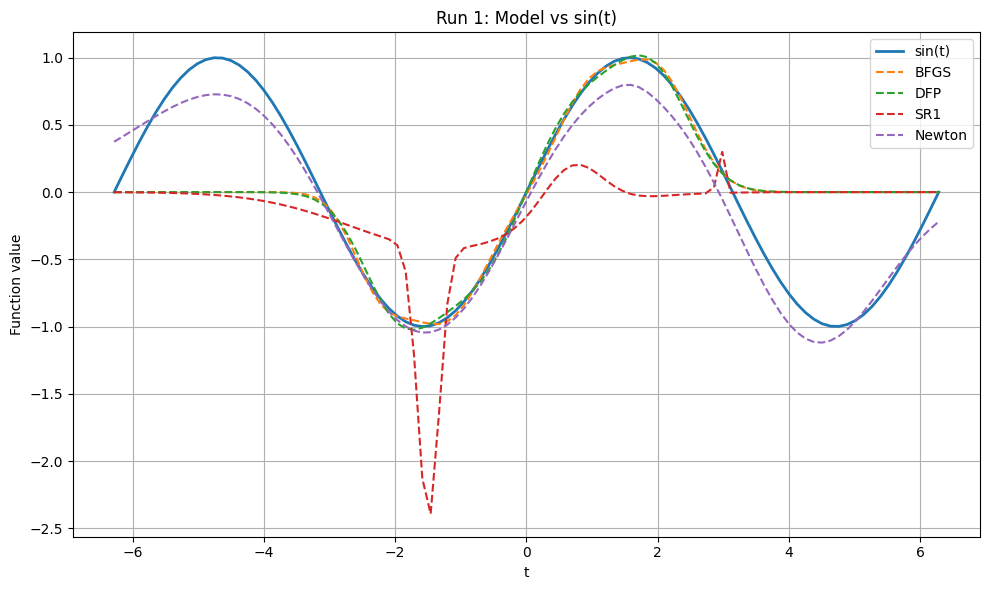


=== Run 2 (scale = 0.4) ===

BFGS
Final ||x̄ - x*||: 18.519087
ℓₖ = 1.001525, qₖ = 0.054163 → Diverging or very slow
Runtime: 3.1409s

DFP
Final ||x̄ - x*||: 4.769227
ℓₖ = 1.000094, qₖ = 0.209717 → Diverging or very slow
Runtime: 3.2216s

SR1
Final ||x̄ - x*||: 6.523533
ℓₖ = 0.998592, qₖ = 0.152860 → Superlinear
Runtime: 2.0226s

Newton
Final ||x̄ - x*||: 2.826811
ℓₖ = 1.000142, qₖ = 0.353856 → Diverging or very slow
Runtime: 5.3966s


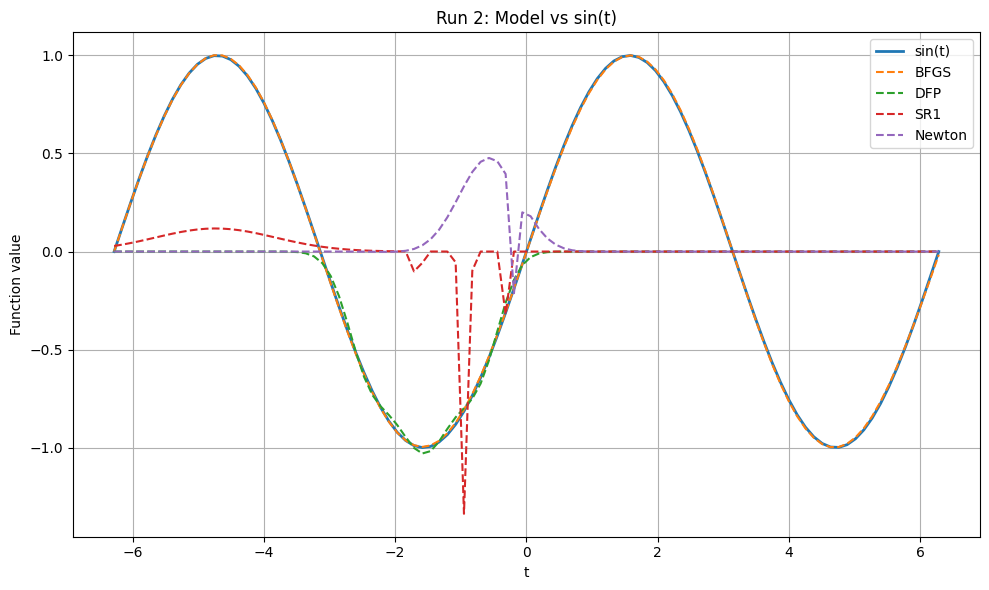


=== Run 3 (scale = 0.6) ===

BFGS
Final ||x̄ - x*||: 3.699182
ℓₖ = 0.998916, qₖ = 0.269744 → Superlinear
Runtime: 3.2927s

DFP
Final ||x̄ - x*||: 3.676127
ℓₖ = 0.999038, qₖ = 0.271503 → Superlinear
Runtime: 3.2145s

SR1
Final ||x̄ - x*||: 3.165517
ℓₖ = 1.009951, qₖ = 0.322223 → Diverging or very slow
Runtime: 2.0065s
Hessian ill-conditioned at iteration 1 (cond = 2.28e+19).

Newton
Final ||x̄ - x*||: 3.597255
ℓₖ = 1.095288, qₖ = 0.333492 → Diverging or very slow
Runtime: 0.0649s


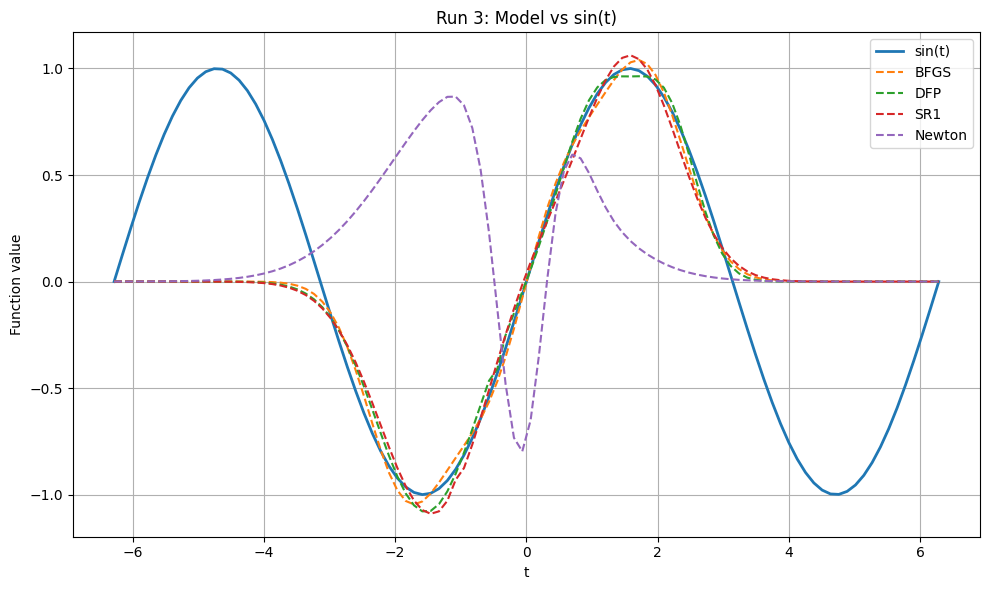


=== Run 4 (scale = 0.8) ===

BFGS
Final ||x̄ - x*||: 20.363640
ℓₖ = 1.019876, qₖ = 0.051079 → Diverging or very slow
Runtime: 3.1751s

DFP
Final ||x̄ - x*||: 3.937044
ℓₖ = 1.026636, qₖ = 0.267709 → Diverging or very slow
Runtime: 0.8944s

SR1
Final ||x̄ - x*||: 5.051901
ℓₖ = 1.096877, qₖ = 0.238156 → Diverging or very slow
Runtime: 1.9981s

Newton
Final ||x̄ - x*||: 3.523995
ℓₖ = 0.997414, qₖ = 0.282303 → Superlinear
Runtime: 5.0798s


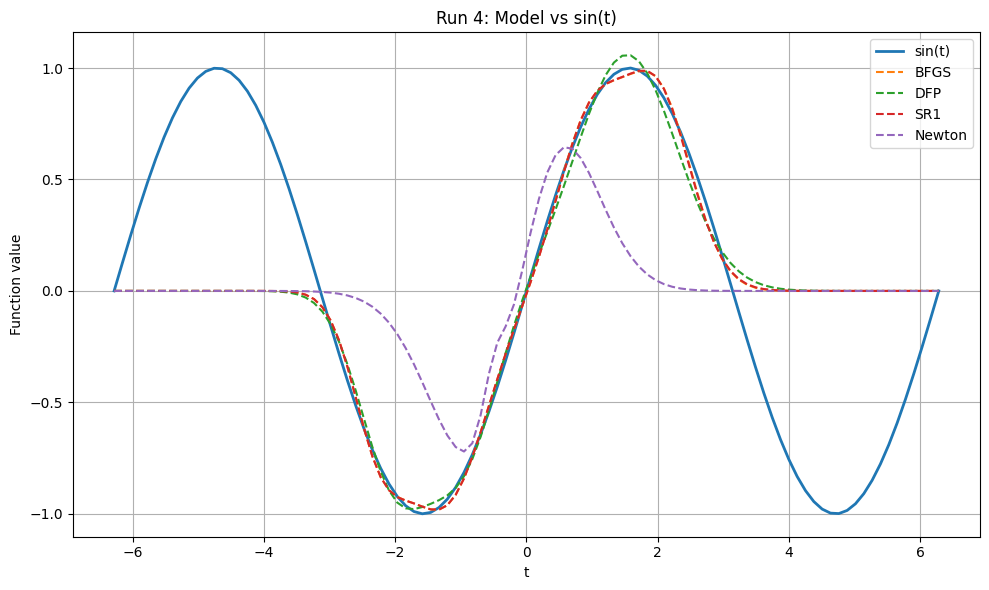


=== Run 5 (scale = 1.0) ===

BFGS
Final ||x̄ - x*||: 14.774995
ℓₖ = 0.991916, qₖ = 0.066592 → Superlinear
Runtime: 3.1697s

DFP
Final ||x̄ - x*||: 6.173905
ℓₖ = 1.024467, qₖ = 0.169995 → Diverging or very slow
Runtime: 2.2671s

SR1
Final ||x̄ - x*||: 8.568576
ℓₖ = 1.114857, qₖ = 0.145054 → Diverging or very slow
Runtime: 1.9858s
Hessian ill-conditioned at iteration 7 (cond = 3.20e+18).

Newton
Final ||x̄ - x*||: 8.806992
ℓₖ = 1.494907, qₖ = 0.253747 → Diverging or very slow
Runtime: 0.3168s


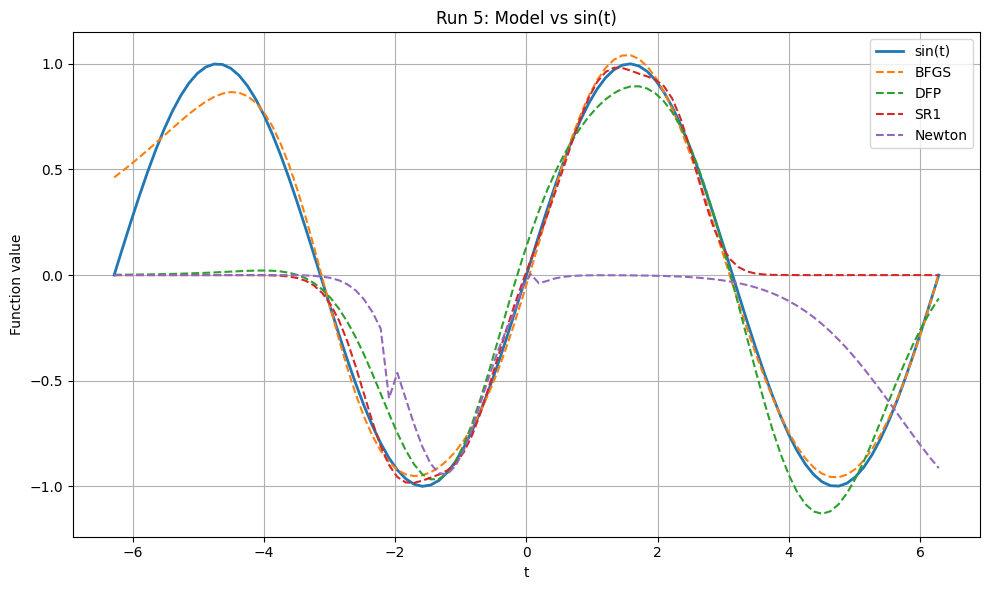


=== Run 6 (scale = 1.2) ===

BFGS
Final ||x̄ - x*||: 10.763850
ℓₖ = 1.018292, qₖ = 0.096333 → Diverging or very slow
Runtime: 3.2093s

DFP
Final ||x̄ - x*||: 6.656554
ℓₖ = 0.998827, qₖ = 0.149876 → Superlinear
Runtime: 3.1713s

SR1
Final ||x̄ - x*||: 3.335106
ℓₖ = 0.808547, qₖ = 0.196020 → Superlinear
Runtime: 1.9960s
Hessian ill-conditioned at iteration 2 (cond = 4.94e+15).

Newton
Final ||x̄ - x*||: 25.904418
ℓₖ = 7.143775, qₖ = 1.970070 → Diverging or very slow
Runtime: 0.1002s


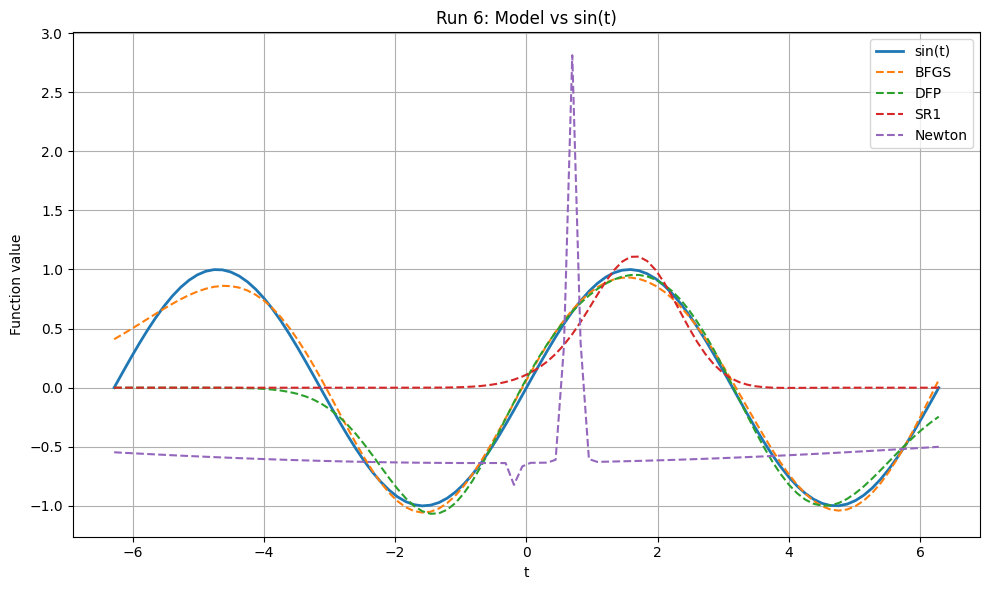


=== Run 7 (scale = 1.4) ===

BFGS
Final ||x̄ - x*||: 20.964860
ℓₖ = 1.040106, qₖ = 0.051602 → Diverging or very slow
Runtime: 3.1732s

DFP
Final ||x̄ - x*||: 9.079494
ℓₖ = 1.005658, qₖ = 0.111388 → Diverging or very slow
Runtime: 3.1482s

SR1
Final ||x̄ - x*||: 4.780912
ℓₖ = 1.000000, qₖ = 0.209165 → Superlinear
Runtime: 1.9934s
Hessian ill-conditioned at iteration 17 (cond = 1.14e+12).

Newton
Final ||x̄ - x*||: 11.447559
ℓₖ = 1.022224, qₖ = 0.091281 → Diverging or very slow
Runtime: 0.7774s


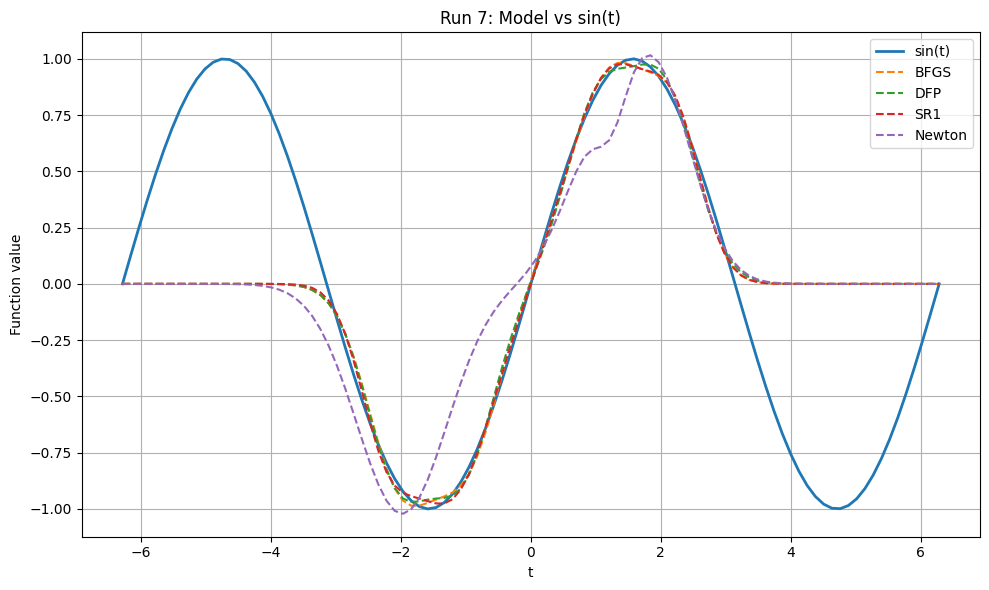


=== Run 8 (scale = 1.6) ===

BFGS
Final ||x̄ - x*||: 11.676016
ℓₖ = 1.020970, qₖ = 0.089275 → Diverging or very slow
Runtime: 3.2701s

DFP
Final ||x̄ - x*||: 7.959994
ℓₖ = 0.999863, qₖ = 0.125594 → Superlinear
Runtime: 3.1669s

SR1
Final ||x̄ - x*||: 25.918500
ℓₖ = 1.008834, qₖ = 0.039267 → Diverging or very slow
Runtime: 2.0020s
Hessian ill-conditioned at iteration 2 (cond = 1.60e+22).

Newton
Final ||x̄ - x*||: 453.809836
ℓₖ = 74.589479, qₖ = 12.259740 → Diverging or very slow
Runtime: 0.1055s


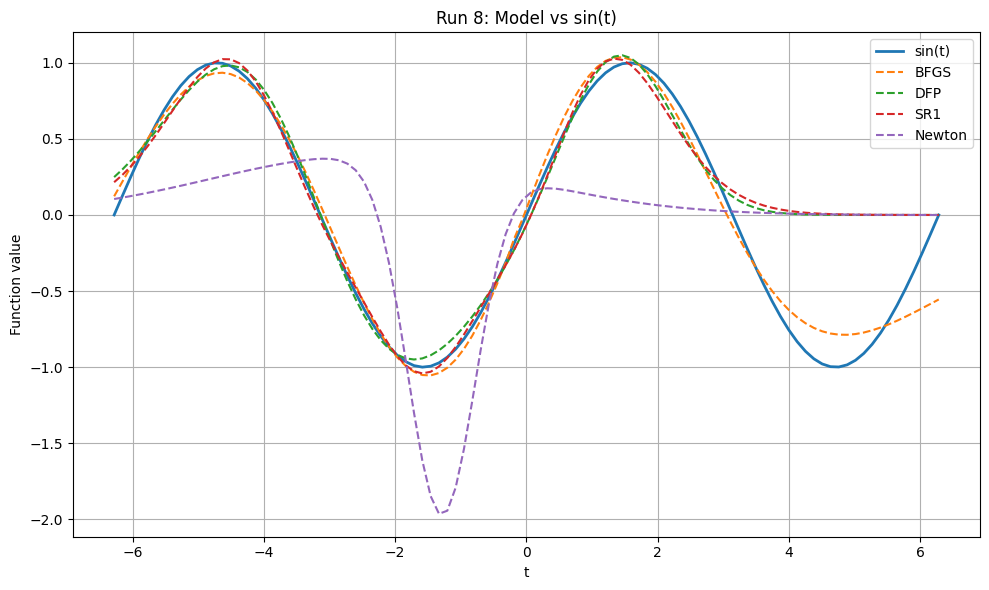


=== Run 9 (scale = 1.8) ===

BFGS
Final ||x̄ - x*||: 17.828715
ℓₖ = 1.005657, qₖ = 0.056726 → Diverging or very slow
Runtime: 3.2484s

DFP
Final ||x̄ - x*||: 9.405833
ℓₖ = 1.027750, qₖ = 0.112300 → Diverging or very slow
Runtime: 3.1399s

SR1
Final ||x̄ - x*||: 5.700538
ℓₖ = 1.000000, qₖ = 0.175422 → Superlinear
Runtime: 1.0252s
Hessian ill-conditioned at iteration 13 (cond = 9.55e+18).

Newton
Final ||x̄ - x*||: 810.026828
ℓₖ = 43.438093, qₖ = 2.329389 → Diverging or very slow
Runtime: 0.7015s


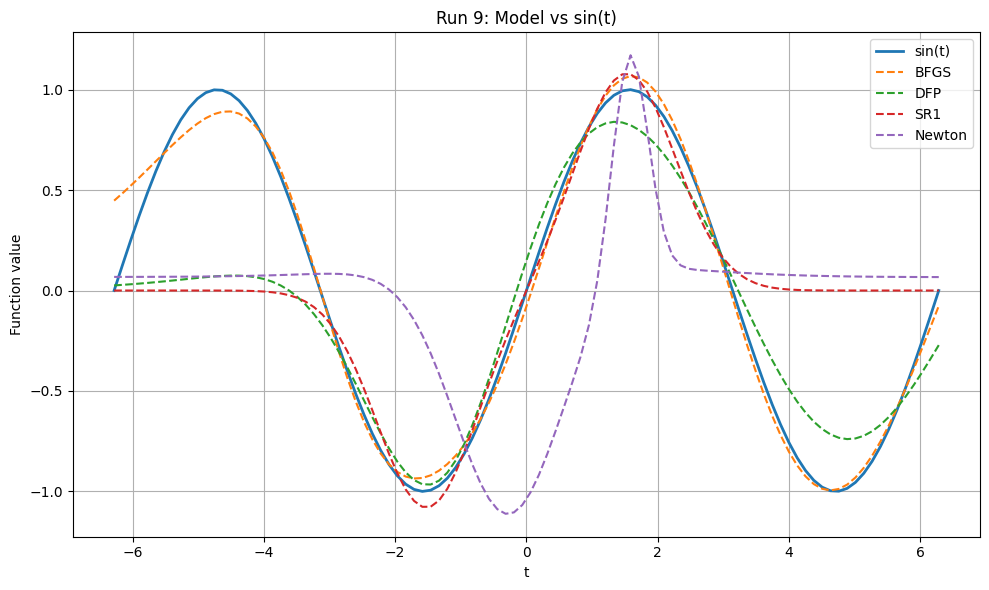


=== Run 10 (scale = 2.0) ===

BFGS
Final ||x̄ - x*||: 3.484499
ℓₖ = 1.000000, qₖ = 0.286985 → Superlinear
Runtime: 1.8801s

DFP
Final ||x̄ - x*||: 4.089650
ℓₖ = 0.998771, qₖ = 0.243919 → Superlinear
Runtime: 3.1320s

SR1
Final ||x̄ - x*||: 7.721298
ℓₖ = 1.075510, qₖ = 0.149809 → Diverging or very slow
Runtime: 1.9734s

Newton
Final ||x̄ - x*||: 26.156904
ℓₖ = 1.003555, qₖ = 0.038503 → Diverging or very slow
Runtime: 4.8874s


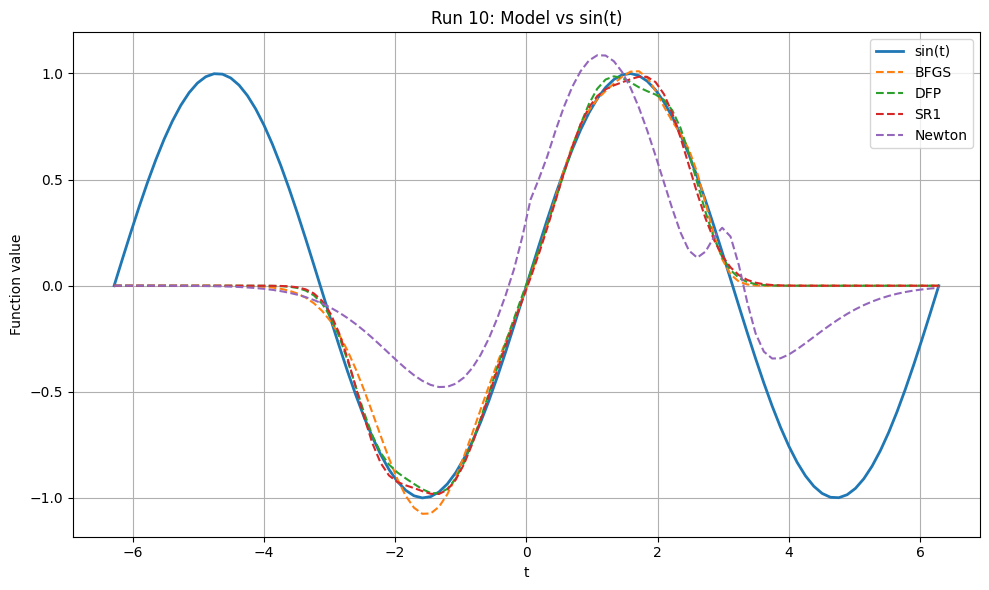


=== Run 11 (scale = 2.2) ===

BFGS
Final ||x̄ - x*||: 722.456293
ℓₖ = 1.036257, qₖ = 0.001486 → Quadratic
Runtime: 3.3267s

DFP
Final ||x̄ - x*||: 16.296815
ℓₖ = 0.983976, qₖ = 0.059411 → Superlinear
Runtime: 0.6850s

SR1
Final ||x̄ - x*||: 11.156667
ℓₖ = 1.017063, qₖ = 0.092717 → Diverging or very slow
Runtime: 2.0266s
Hessian ill-conditioned at iteration 1 (cond = 2.28e+12).

Newton
Final ||x̄ - x*||: 12.158137
ℓₖ = 1.215682, qₖ = 0.121555 → Diverging or very slow
Runtime: 0.0570s


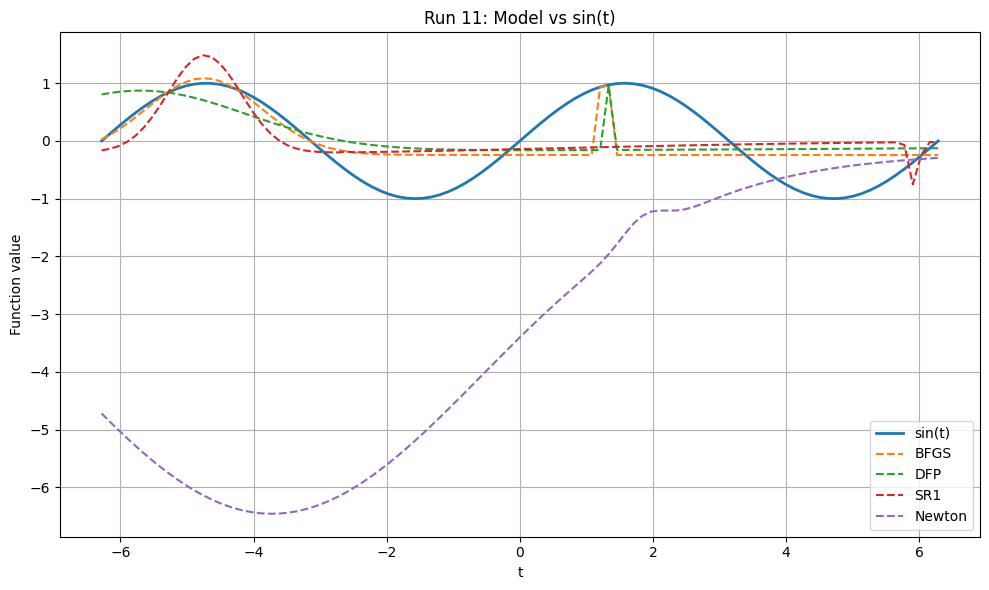


=== Run 12 (scale = 2.4) ===

BFGS
Final ||x̄ - x*||: 67.347981
ℓₖ = 1.004985, qₖ = 0.014997 → Diverging or very slow
Runtime: 3.1864s

DFP
Final ||x̄ - x*||: 19.325007
ℓₖ = 1.001915, qₖ = 0.051945 → Diverging or very slow
Runtime: 3.1666s

SR1
Final ||x̄ - x*||: 6.083908
ℓₖ = 0.983479, qₖ = 0.158982 → Superlinear
Runtime: 2.0069s

Newton
Final ||x̄ - x*||: 6.884750
ℓₖ = 0.999999, qₖ = 0.145248 → Superlinear
Runtime: 4.1131s


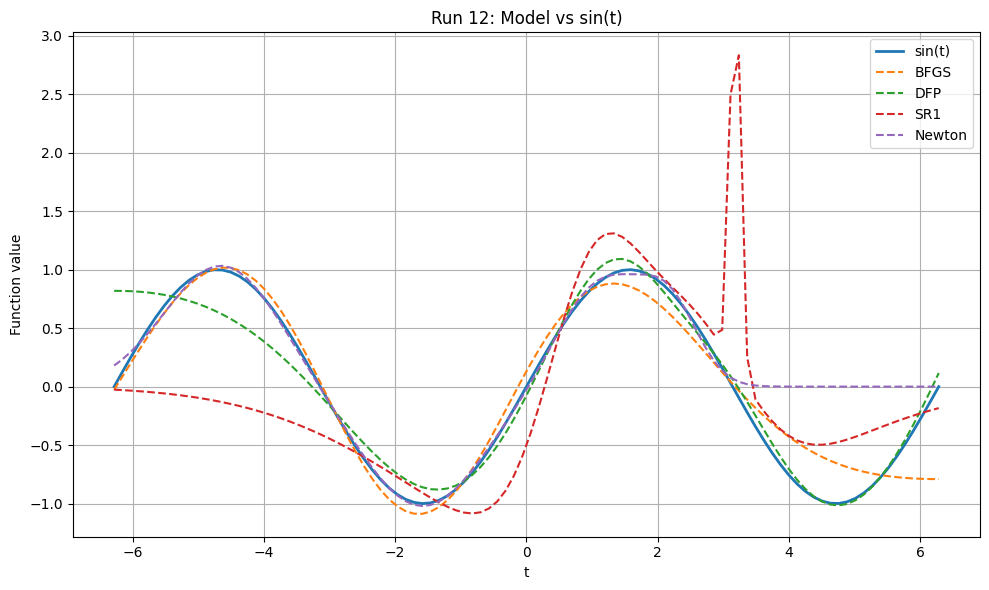


=== Run 13 (scale = 2.6) ===

BFGS
Final ||x̄ - x*||: 74.364680
ℓₖ = 0.994161, qₖ = 0.013291 → Superlinear
Runtime: 3.2908s

DFP
Final ||x̄ - x*||: 12.419756
ℓₖ = 1.000269, qₖ = 0.080560 → Diverging or very slow
Runtime: 3.1850s

SR1
Final ||x̄ - x*||: 14.087374
ℓₖ = 1.069612, qₖ = 0.081212 → Diverging or very slow
Runtime: 2.0099s
Hessian ill-conditioned at iteration 2 (cond = 1.94e+18).

Newton
Final ||x̄ - x*||: 3668.867676
ℓₖ = 42.075423, qₖ = 0.482531 → Diverging or very slow
Runtime: 0.1009s


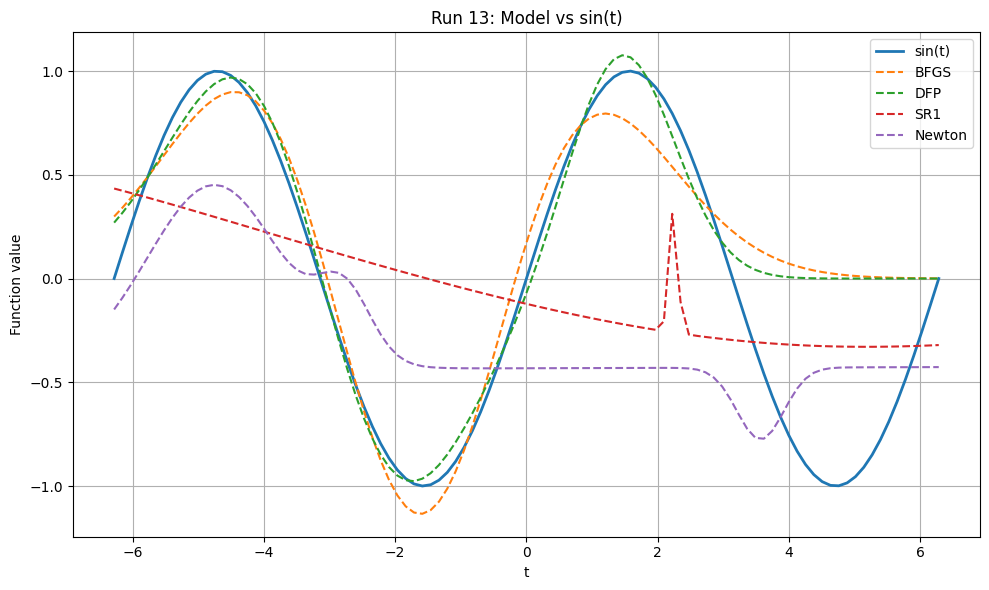


=== Run 14 (scale = 2.8) ===

BFGS
Final ||x̄ - x*||: 42.207451
ℓₖ = 0.986682, qₖ = 0.023066 → Superlinear
Runtime: 3.1914s

DFP
Final ||x̄ - x*||: 10.321789
ℓₖ = 0.999337, qₖ = 0.096754 → Superlinear
Runtime: 1.6199s

SR1
Final ||x̄ - x*||: 12.663249
ℓₖ = 1.023567, qₖ = 0.082735 → Diverging or very slow
Runtime: 1.9810s
Hessian ill-conditioned at iteration 1 (cond = 1.72e+18).

Newton
Final ||x̄ - x*||: 47.030525
ℓₖ = 5.179123, qₖ = 0.570338 → Diverging or very slow
Runtime: 0.0603s


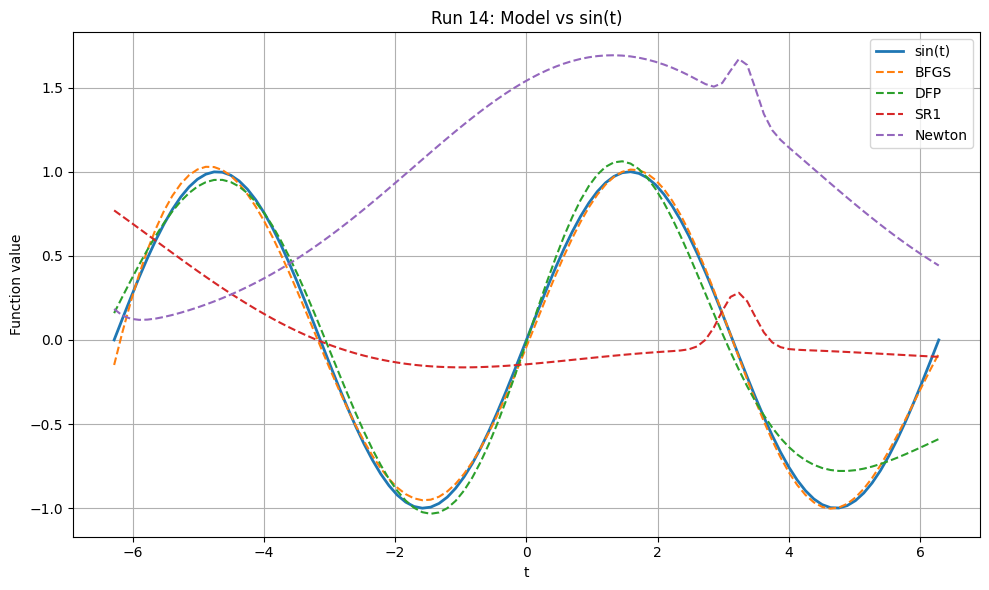


=== Run 15 (scale = 3.0) ===

BFGS
Final ||x̄ - x*||: 122.114699
ℓₖ = 1.056904, qₖ = 0.009148 → Quadratic
Runtime: 3.1980s

DFP
Final ||x̄ - x*||: 45.378191
ℓₖ = 1.163003, qₖ = 0.029807 → Diverging or very slow
Runtime: 1.3178s

SR1
Final ||x̄ - x*||: 15.863553
ℓₖ = 1.018031, qₖ = 0.065331 → Diverging or very slow
Runtime: 2.0290s
Hessian ill-conditioned at iteration 2 (cond = 1.98e+13).

Newton
Final ||x̄ - x*||: 22.778479
ℓₖ = 1.634021, qₖ = 0.117217 → Diverging or very slow
Runtime: 0.1108s


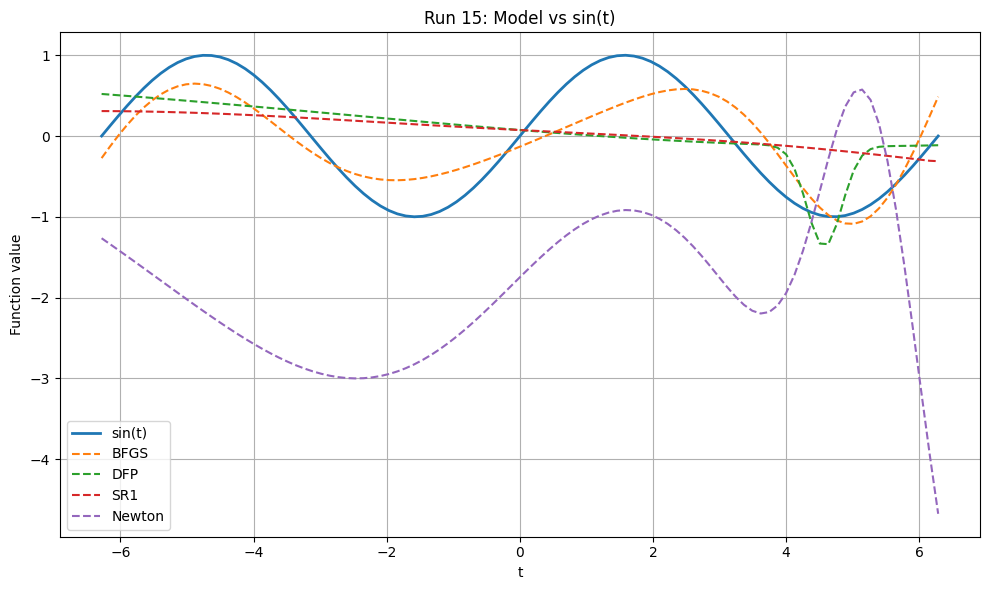


=== Method Summary ===

Method: BFGS
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 2
  Superlinear: 5
  Linear: 0
  Diverging or very slow: 8
Average runtime: 3.1309 seconds

Method: DFP
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 7
  Linear: 0
  Diverging or very slow: 8
Average runtime: 2.5638 seconds

Method: SR1
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 5
  Linear: 0
  Diverging or very slow: 10
Average runtime: 1.9381 seconds

Method: Newton
Successful convergence to x*: 0/15
Rates of convergence distribution:
  Quadratic: 0
  Superlinear: 2
  Linear: 0
  Diverging or very slow: 13
Average runtime: 1.7555 seconds


In [19]:
methods = [bfgs_method, dfp_method, sr1_method, newton_method]
method_names = ["BFGS", "DFP", "SR1", "Newton"]
scales = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0]
num_runs = len(scales)
evaluate_all_runs(objective, phi, x0, methods, method_names, a, b, num_runs, scales)